# Import libraries

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Read and preprocess the dataset

In [27]:
# Read the datasets
train_calc = pd.read_csv('calc_case_description_train_set.csv')
test_calc = pd.read_csv('calc_case_description_test_set.csv')
train_mass = pd.read_csv('mass_case_description_train_set.csv')
test_mass = pd.read_csv('mass_case_description_test_set.csv')

# Combine train and test datasets
calc = pd.concat([train_calc, train_calc], axis=0)
mass = pd.concat([train_mass, test_mass], axis=0)

In [28]:
mean_calc = calc.mean()
std_calc = calc.std()

mean_mass = mass.mean()
std_mass = mass.std()

C:\Users\teewi\AppData\Local\Temp\ipykernel_25616\3867711381.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_calc = calc.mean()
C:\Users\teewi\AppData\Local\Temp\ipykernel_25616\3867711381.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_calc = calc.std()
C:\Users\teewi\AppData\Local\Temp\ipykernel_25616\3867711381.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select onl

In [29]:
calc.keys()

Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [30]:
mass.keys()

Index(['patient_id', 'breast_density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'mass shape', 'mass margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')

In [31]:
def preprocess(data):
        # make a copy of the data to avoid SettingWithCopyWarning
        data = data.copy()
        
        # set the limitations on the numerical columns
        try:
                data['breast density'] = data['breast density'].clip(1, 4)
        except KeyError:
                data['breast_density'] = data['breast_density'].clip(1, 4)
        data['abnormality id'] = data['abnormality id'].clip(0)
        data['assessment'] = data['assessment'].clip(0, 5)
        data['subtlety'] = data['subtlety'].clip(1, 5)
        
        # change the name of index
        data.index = data['patient_id'] + '_' + data['image view'] + '_' \
        + data['left or right breast'] + '_' + data['abnormality id'].astype(str)

        # Remove useless columns
        data = data[data.columns.drop(list(data.filter(regex='file path')) 
                + ['image view', 'patient_id', 'left or right breast', 'abnormality type'])]

        # Fill NaN values with appropriate placeholders
        try:
                data['calc type'] = data['calc type'].fillna('None')
                data['calc distribution'] = data['calc distribution'].fillna('None')
        except KeyError:
                data['mass shape'] = data['mass shape'].fillna('None')
                data['mass margins'] = data['mass margins'].fillna('None')

        # Encode categorical features
        le_pathology = LabelEncoder()
        try:
                le_type = LabelEncoder()
                le_distribution = LabelEncoder()
                
                data['calc type'] = le_type.fit_transform(data['calc type'])
                data['calc distribution'] = le_distribution.fit_transform(data['calc distribution'])
                
        except KeyError:
                le_shape = LabelEncoder()
                le_distribution = LabelEncoder()
                
                data['mass shape'] = le_shape.fit_transform(data['mass shape'])
                data['mass margins'] = le_distribution.fit_transform(data['mass margins'])
        data['pathology'] = le_pathology.fit_transform(data['pathology'])
        
        # rename columns
        data.rename(columns={'abnormality id': 'number of abnormality', 
                             'assessment' : 'overall BI-RADS assessment'}, inplace=True)
        try:
                data.rename(columns={'breast_density' : 'breast density'}, inplace=True)
        except KeyError:
                pass

        # Split the data back into train and test datasets
        return train_test_split(data, test_size=0.2, random_state=42)

# Split the data back into train and test datasets
train_calc, test_calc = preprocess(calc)
train_mass, test_mass = preprocess(mass)

In [32]:
train_calc[:3]

,breast density,number of abnormality,calc type,calc distribution,overall BI-RADS assessment,pathology,subtlety
P_00150_MLO_RIGHT_1,3,1,10,0,4,2,2
P_02153_MLO_RIGHT_1,2,1,0,0,0,0,2
P_00202_MLO_RIGHT_2,1,2,10,1,5,2,5


In [33]:
train_mass[:3]

,breast density,number of abnormality,mass shape,mass margins,overall BI-RADS assessment,pathology,subtlety
P_01178_CC_RIGHT_1,3,1,14,7,4,0,3
P_00711_MLO_RIGHT_1,2,1,17,0,2,0,3
P_00673_MLO_RIGHT_1,1,1,16,0,2,1,4


[Text(0.4107142857142857, 0.9705882352941176, 'x[4] <= 2.5\ngini = 0.645\nsamples = 521\nvalue = [201, 111, 209]'),
 Text(0.12987012987012986, 0.9117647058823529, 'x[4] <= 1.0\ngini = 0.332\nsamples = 138\nvalue = [18, 111, 9]'),
 Text(0.07792207792207792, 0.8529411764705882, 'x[5] <= 3.5\ngini = 0.495\nsamples = 20\nvalue = [11, 0, 9]'),
 Text(0.05194805194805195, 0.7941176470588235, 'x[2] <= 5.0\ngini = 0.391\nsamples = 15\nvalue = [11, 0, 4]'),
 Text(0.025974025974025976, 0.7352941176470589, 'gini = 0.0\nsamples = 6\nvalue = [6, 0, 0]'),
 Text(0.07792207792207792, 0.7352941176470589, 'x[0] <= 3.5\ngini = 0.494\nsamples = 9\nvalue = [5, 0, 4]'),
 Text(0.05194805194805195, 0.6764705882352942, 'gini = 0.0\nsamples = 4\nvalue = [0, 0, 4]'),
 Text(0.1038961038961039, 0.6764705882352942, 'gini = 0.0\nsamples = 5\nvalue = [5, 0, 0]'),
 Text(0.1038961038961039, 0.7941176470588235, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 5]'),
 Text(0.18181818181818182, 0.8529411764705882, 'x[3] <= 6.0\ngin

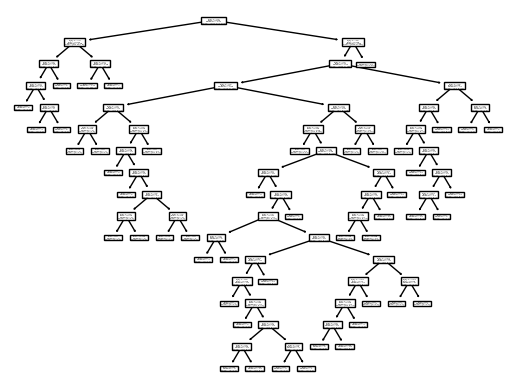

In [41]:
# create a decision tree
model = tree.DecisionTreeClassifier()
model.fit(train_calc.drop('pathology', axis=1), train_calc['pathology'])
tree.plot_tree(model)

In [35]:
# test the model
model.score(train_calc.drop('pathology', axis=1), train_calc['pathology'])


0.9059500959692899

In [36]:
model.score(test_calc.drop('pathology', axis=1), test_calc['pathology'])

0.916030534351145

In [42]:
# test prediction
model.predict(test_calc.drop('pathology', axis=1))

array([2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 1, 0, 0, 2, 1, 2, 2,
       0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 1, 0,
       0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 2, 0, 2, 1, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 0, 0, 1, 2, 2, 0, 2,
       0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1])

In [43]:
# convert column to array
test_calc['pathology'].to_numpy()


array([2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2, 2, 1, 2, 2,
       0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 0, 0,
       0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 1, 0,
       0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 0,
       0, 0, 0, 2, 1, 0, 2, 0, 0, 2, 0, 2, 1, 0, 1, 0, 0, 1, 2, 2, 0, 2,
       2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 2, 0, 1, 1])

In [50]:
# diff
test_calc['pathology'].to_numpy() - model.predict(test_calc.drop('pathology', axis=1))

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,  0,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  2,  2,  0,  0,  2,  0,  0,  0])

In [21]:
# test how the subtlety column affects the model
model2 = tree.DecisionTreeClassifier()
model2.fit(train_calc.drop(['pathology', 'subtlety'], axis=1), train_calc['pathology'])
model2.score(test_calc.drop(['pathology', 'subtlety'], axis=1), test_calc['pathology'])

0.8778625954198473

In [46]:
# target column: assessment, remove pathology
model3 = tree.DecisionTreeClassifier()
model3.fit(train_calc.drop(['pathology', 'overall BI-RADS assessment'], axis=1), train_calc['overall BI-RADS assessment'])
model3.score(test_calc.drop(['pathology', 'overall BI-RADS assessment'], axis=1), test_calc['overall BI-RADS assessment'])

0.9389312977099237

[Text(0.7370867768595041, 0.9545454545454546, 'x[3] <= 4.5\ngini = 0.642\nsamples = 521\nvalue = [20, 118, 43, 278, 62]'),
 Text(0.5733471074380165, 0.8636363636363636, 'x[4] <= 4.5\ngini = 0.5\nsamples = 358\nvalue = [16, 7, 40, 244, 51]'),
 Text(0.36983471074380164, 0.7727272727272727, 'x[2] <= 8.5\ngini = 0.406\nsamples = 301\nvalue = [16, 3, 34, 228, 20]'),
 Text(0.2066115702479339, 0.6818181818181818, 'x[4] <= 3.5\ngini = 0.693\nsamples = 78\nvalue = [7, 3, 17, 36, 15]'),
 Text(0.11570247933884298, 0.5909090909090909, 'x[2] <= 2.5\ngini = 0.594\nsamples = 62\nvalue = [6, 1, 17, 35, 3]'),
 Text(0.08264462809917356, 0.5, 'x[0] <= 2.5\ngini = 0.453\nsamples = 38\nvalue = [6, 0, 5, 27, 0]'),
 Text(0.06611570247933884, 0.4090909090909091, 'x[1] <= 1.5\ngini = 0.654\nsamples = 19\nvalue = [6, 0, 5, 8, 0]'),
 Text(0.049586776859504134, 0.3181818181818182, 'x[4] <= 2.5\ngini = 0.664\nsamples = 16\nvalue = [6, 0, 5, 5, 0]'),
 Text(0.03305785123966942, 0.22727272727272727, 'x[0] <= 1.5\ngin

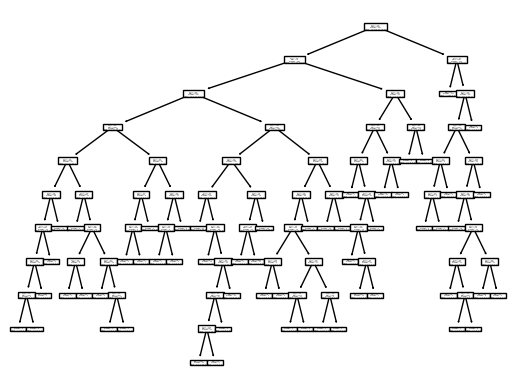

In [51]:
tree.plot_tree(model3)

In [47]:
model3.predict(test_calc.drop(['pathology', 'overall BI-RADS assessment'], axis=1))

array([3, 4, 0, 4, 2, 4, 5, 4, 4, 5, 4, 4, 4, 5, 4, 2, 3, 4, 4, 2, 4, 4,
       4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 5, 4, 5, 4, 2, 4, 2, 4, 4,
       3, 2, 3, 4, 4, 2, 0, 5, 4, 0, 4, 4, 4, 0, 4, 3, 5, 4, 4, 4, 2, 4,
       4, 4, 4, 5, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 5, 4, 3, 2, 0,
       4, 4, 4, 4, 2, 4, 4, 4, 0, 5, 4, 3, 2, 4, 2, 4, 4, 2, 4, 5, 4, 3,
       4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 2, 4, 4, 4, 4, 2, 4, 4, 4, 2, 2],
      dtype=int64)

In [48]:
# compare the prediction with the actual value
test_calc['overall BI-RADS assessment'].to_numpy()

array([3, 4, 4, 4, 2, 4, 5, 4, 4, 5, 4, 4, 4, 5, 4, 2, 0, 4, 5, 2, 4, 4,
       4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 5, 4, 5, 4, 2, 4, 2, 4, 4,
       3, 2, 3, 4, 4, 2, 0, 5, 4, 0, 4, 4, 4, 0, 4, 0, 5, 4, 4, 5, 2, 4,
       4, 4, 4, 5, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 5, 4, 3, 2, 4,
       4, 4, 4, 4, 2, 4, 4, 4, 0, 5, 4, 3, 2, 4, 2, 4, 4, 2, 4, 5, 4, 5,
       4, 4, 4, 5, 5, 4, 4, 4, 4, 5, 2, 4, 4, 4, 4, 2, 4, 4, 4, 2, 2],
      dtype=int64)

In [49]:
# diff
test_calc['overall BI-RADS assessment'].to_numpy() - model3.predict(test_calc.drop(['pathology', 'overall BI-RADS assessment'], axis=1))

array([ 0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -3,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int64)

# Data Analysation

# DATASETS & DATALOADERS

In [9]:
# dataset and dataloader for calcification dataset
class BreastCancerDatasetCalc(Dataset):
    def __init__(self, df):
        self.data = df
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        features = torch.tensor([row['breast_density'], row['number_of_abnormality'],
                                row['calcification_type'], row['calcification_distribution'],
                                row['subtlety_rating']])
        overall_BI_RADS_assessment = torch.tensor(row['overall_BI-RADS_assessment'])
        pathology = torch.tensor(row['pathology'])
        
        return features, overall_BI_RADS_assessment, pathology

train_calc_dataset = BreastCancerDatasetCalc(train_calc)
test_calc_dataset = BreastCancerDatasetCalc(test_calc)

train_calc_loader = DataLoader(train_calc_dataset, batch_size=32, shuffle=True)
test_calc_loader = DataLoader(test_calc_dataset, batch_size=32, shuffle=False)

In [10]:
# dataset and dataloader for mass dataset
class BreastCancerDatasetMass(Dataset):
    def __init__(self, df):
        self.data = df
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        features = torch.tensor([row['breast_density'], row['number_of_abnormality'],
                                row['mass_shape'], row['mass_margins'],
                                row['subtlety_rating']])
        overall_BI_RADS_assessment = torch.tensor(row['overall_BI-RADS_assessment'])
        pathology = torch.tensor(row['pathology'])
        
        return features, overall_BI_RADS_assessment, pathology

train_mass_dataset = BreastCancerDatasetMass(train_mass)
test_mass_dataset = BreastCancerDatasetMass(test_mass)

train_mass_loader = DataLoader(train_mass_dataset, batch_size=32, shuffle=True)
test_mass_loader = DataLoader(test_mass_dataset, batch_size=32, shuffle=False)

# Transforms

In [11]:
# Create a custom transform function to add random noise to the features
class AddRandomNoise(object):
    def __init__(self, noise_std=0.1):
        self.noise_std = noise_std

    def __call__(self, features):
        noise = torch.tensor(np.random.normal(0, self.noise_std, features.shape), dtype=torch.float32)
        noisy_features = features + noise
        return noisy_features

In [12]:
# Update the BreastCancerDatasetCalc class to accept multiple transforms
class BreastCancerDatasetCalc(Dataset):
    def __init__(self, df, transforms=None):
        self.data = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        features = torch.tensor([row['breast_density'], row['number_of_abnormality'],
                                row['calcification_type'], row['calcification_distribution'],
                                row['subtlety_rating']])
        
        if self.transforms:
            for transform in self.transforms:
                features = transform(features)
        
        overall_BI_RADS_assessment = torch.tensor(row['overall_BI-RADS_assessment'])
        pathology = torch.tensor(row['pathology'])
        
        return features, overall_BI_RADS_assessment, pathology

In [13]:
# Update the BreastCancerDatasetMass class to accept multiple transforms
class BreastCancerDatasetMass(Dataset):
    def __init__(self, df, transforms=None):
        self.data = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        features = torch.tensor([row['breast_density'], row['number_of_abnormality'],
                                row['mass_shape'], row['mass_margins'],
                                row['subtlety_rating']])
        
        if self.transforms:
            for transform in self.transforms:
                features = transform(features)
        
        overall_BI_RADS_assessment = torch.tensor(row['overall_BI-RADS_assessment'])
        pathology = torch.tensor(row['pathology'])
        
        return features, overall_BI_RADS_assessment, pathology

In [14]:
# Create instances of NormalizeFeatures and AddRandomNoise, then pass them to the dataset
class NormalizeFeatures(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, features):
        normalized_features = (features - self.mean) / self.std
        return normalized_features

In [15]:
normalize_transform = NormalizeFeatures(mean_calc, std_calc)
noise_transform = AddRandomNoise(noise_std=0.1)

train_calc_dataset = BreastCancerDatasetCalc(train_calc, transforms=[normalize_transform, noise_transform])
test_calc_dataset = BreastCancerDatasetCalc(test_calc, transforms=[normalize_transform]) # Do not apply noise to test data

train_calc_loader = DataLoader(train_calc_dataset, batch_size=32, shuffle=True)
test_calc_loader = DataLoader(test_calc_dataset, batch_size=32, shuffle=False)

In [16]:
normalize_transform = NormalizeFeatures(mean_mass, std_mass)
noise_transform = AddRandomNoise(noise_std=0.1)

train_mass_dataset = BreastCancerDatasetCalc(train_mass, transforms=[normalize_transform, noise_transform])
test_mass_dataset = BreastCancerDatasetCalc(test_mass, transforms=[normalize_transform]) # Do not apply noise to test data

train_mass_loader = DataLoader(train_mass_dataset, batch_size=32, shuffle=True)
test_mass_loader = DataLoader(test_mass_dataset, batch_size=32, shuffle=False)